# Six-bar mechanism balancing

###### Luis Eduardo Robles Jiménez

With this work, I pretend to find out the behavior of the function with different tools, in order to understand what are the most important variables, find patterns, identify overlapping zones of minima between the functions we're optimizing, graphing data, etc.

In [1]:
from BetaShF import *
from BetaShM import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import scipy as sp
import time


assert ShF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) == 1.0
assert ShM([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) == 1.0

#### Constraints

$$ -0.16m \leq x_{cn}, y_{cn} \leq 0.16m $$

$$ 0.005m \leq t_{cn} \leq 0.04m $$

#### Objective function

In [14]:
def objective(s, ShF, ShM):
    return 0.5*ShF(s) + 0.5*ShM(s)

## Mathematical analysis 

## Sample generation

In [2]:
nSamples, nVariables = 250, 15
nWeights = nVariables // 3
samples = np.zeros((nSamples, nVariables))
bounds = np.zeros((nVariables, 2))
fitness = np.zeros((nSamples))

In [15]:
extraSamples = np.zeros((nSamples, nVariables))
extraFitness = np.zeros((nSamples))

In [16]:
for i in range(nVariables):
    if (i + 1) % 3 == 0: extraSamples[:, i] = np.random.uniform(0.005, 0.04, (nSamples))
    else: extraSamples[:, i] = np.random.uniform(-0.16, 0.16, (nSamples))
for i in range(nSamples):
    extraFitness[i] = objective(extraSamples[i], ShF, ShM)
"""
for v in range(nVariables):
    bounds[v] = [0.005, 0.04] if (v + 1) % 3 == 0 else [-0.16, 0.16]
worst = 0.0
for s in range(nSamples):
    print("\rIteration:", s, "\tWorst fitness:", worst, end = "")
    p = False
    if s < nSamples // 10: p = True
    r = sp.optimize.differential_evolution(objective, bounds, args = (ShF, ShM), maxiter = 25, popsize = 10, polish = p)
    samples[s] = r.x
    fitness[s] = r.fun
    worst = np.max([worst, fitness[s]])
"""

'\nfor v in range(nVariables):\n    bounds[v] = [0.005, 0.04] if (v + 1) % 3 == 0 else [-0.16, 0.16]\nworst = 0.0\nfor s in range(nSamples):\n    print("\rIteration:", s, "\tWorst fitness:", worst, end = "")\n    p = False\n    if s < nSamples // 10: p = True\n    r = sp.optimize.differential_evolution(objective, bounds, args = (ShF, ShM), maxiter = 25, popsize = 10, polish = p)\n    samples[s] = r.x\n    fitness[s] = r.fun\n    worst = np.max([worst, fitness[s]])\n'

In [19]:
samples = np.vstack((samples, extraSamples))

In [29]:
fitness = np.loadtxt("1671919014Fitness.txt")
fitness = np.hstack((fitness, extraFitness))
fitness.shape

(500,)

In [22]:
nSamples *= 2

### Write data to a file

In [20]:
now = str(int(time.time()))
np.savetxt(now + "Population.txt", samples)
np.savetxt(now + "Fitness.txt", fitness)

### Read data from a file

In [3]:
"""
# The very best examples, to understand how good solutions behave
fitness = np.loadtxt("1671649703Fitness.txt")
samples = np.loadtxt("1671649703Population.txt")
"""

# Solutions under 1.0
fitness = np.loadtxt("1671919014Fitness.txt")
samples = np.loadtxt("1671919014Population.txt")


## Dimensionality reduction

### Feature selection

### Feature extraction

#### Masses

This is a problem-specific feature that we can get from the variables.

These calculations are intended to be used later on to find out where this is a good representative of the solutions or not.

The mass can be easily calculated with the resulting formula of the following steps.

#### Formula

$$\sigma_i = \frac{m_i}{V_i}$$

$$m_i = V_i \sigma_i$$

$$m_i = (r_i^2 t_i \pi)(\sigma_i)$$

$$m_i = (\sqrt{x_i^2 + y_i^2}^2 t_i \pi)(\sigma_i)$$

$$m_i = (x_i^2 + y_i^2) t_i \pi\sigma_i$$

#### Considering that

$\sigma$ is density. In this problem: $\sigma_i = 7800 \frac{kg}{m^3}$

$m$ is mass $(kg)$

$V$ is volume; of a cylinder in this problem $(m^3)$ 

$x, y$ are the relative coordinates of the weight centers. $(m)$

In [23]:
masses = np.zeros((nSamples, nWeights))
density = 7800
for i in range(nWeights):
    masses[:, i] = (samples[:, i*3]**2 + samples[:, i*3 + 1]**2) * samples[:, i*3 + 2] * np.pi * density

#### PCA

In [24]:
modelPCA = PCA()
modelPCA.fit(samples)
dataPCA = modelPCA.transform(samples)
dataPCA.shape

(500, 15)

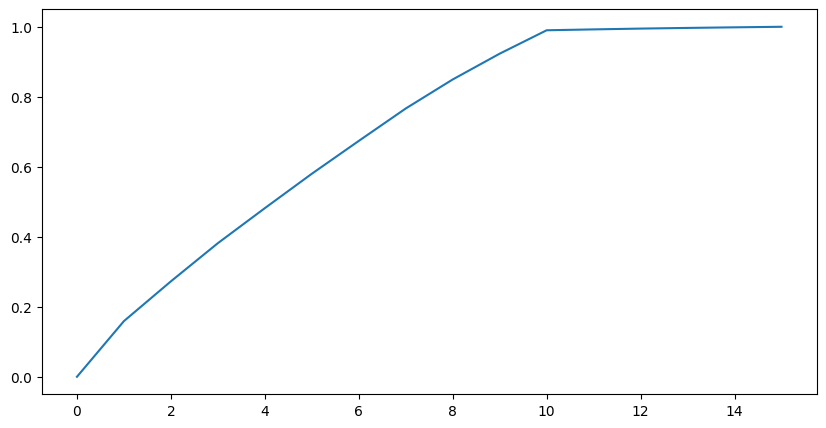

In [25]:
expVar = modelPCA.explained_variance_ratio_
expVarCum = np.cumsum(expVar)
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate(([0], expVarCum)))
plt.show()

## Data visualization

### First two main components

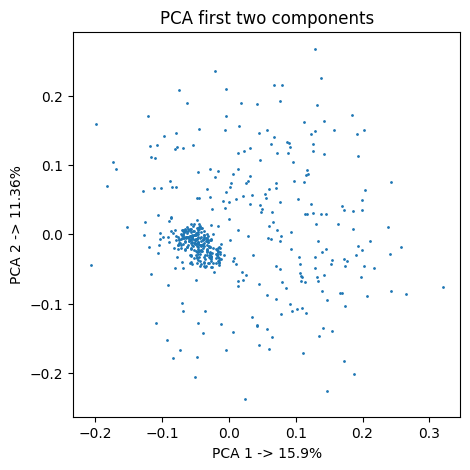

In [26]:
dataPCA = dataPCA[:, :2]
plt.figure(figsize=(5, 5))
plt.title("PCA first two components")
plt.scatter(dataPCA[:, 0], dataPCA[:, 1], s = 1)
plt.xlabel("PCA 1 -> " + str(np.round(expVar[0]*100, 2)) + "%")
plt.ylabel("PCA 2 -> " + str(np.round(expVar[1]*100, 2)) + "%")
plt.show()

### Parallel coordinates 

In [28]:
fitness.shape

(2, 250)

In [30]:
fig = px.parallel_coordinates(samples, title = "Mechanism balancing samples",
                            color = fitness,
                            labels=["x One", "y One", "t One", "x Two", "y Two", "t Two", "x Three", "y Three", "t Three", "x Four", "y Four", "t Four", "x Five", "y Five", "t Five", "Fitness"],
                            color_continuous_scale=px.colors.sequential.Hot)
fig.show()

### Violinplot

This graph is created with hopes of seeing if the masses have a tendency. 

Also maybe conclude that the heavier a weight is, the more importance it has.

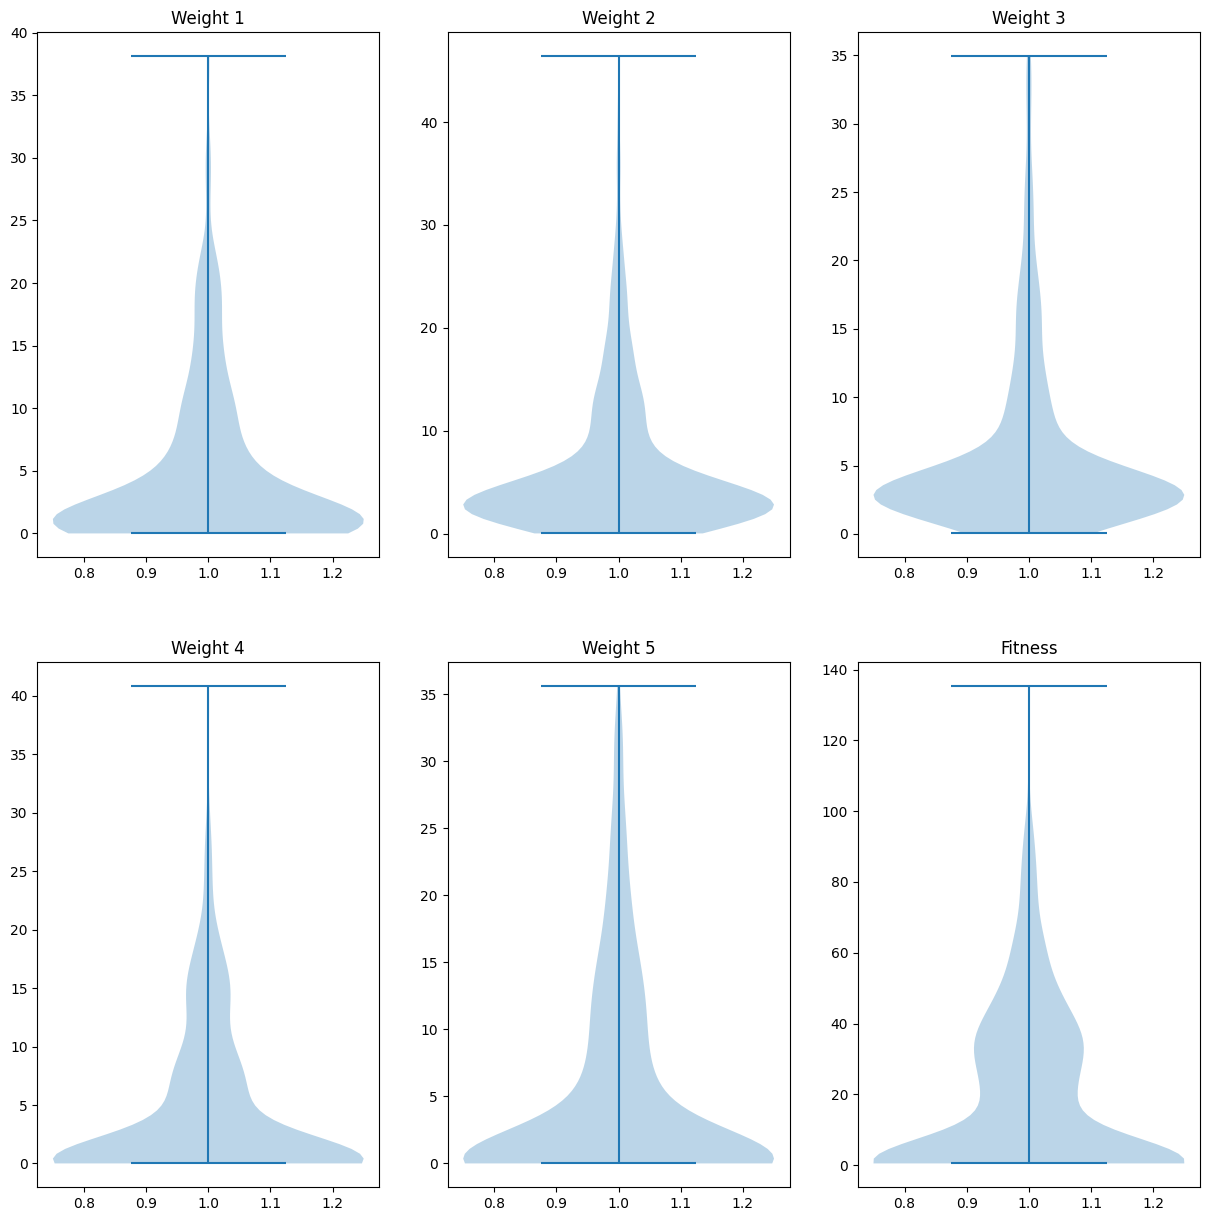

In [31]:
fig = plt.figure(figsize =(15, 15))
for i in range(nWeights):
    plt.subplot(2, 3, i + 1)
    plt.title("Weight " + str(i + 1))
    plt.violinplot(masses[:, i])
plt.subplot(2, 3, 6)
plt.title("Fitness")
plt.violinplot(fitness)
plt.show()


### Scatter plot

Let's try to see if there's a relation between the masses of the weights and their fitness.

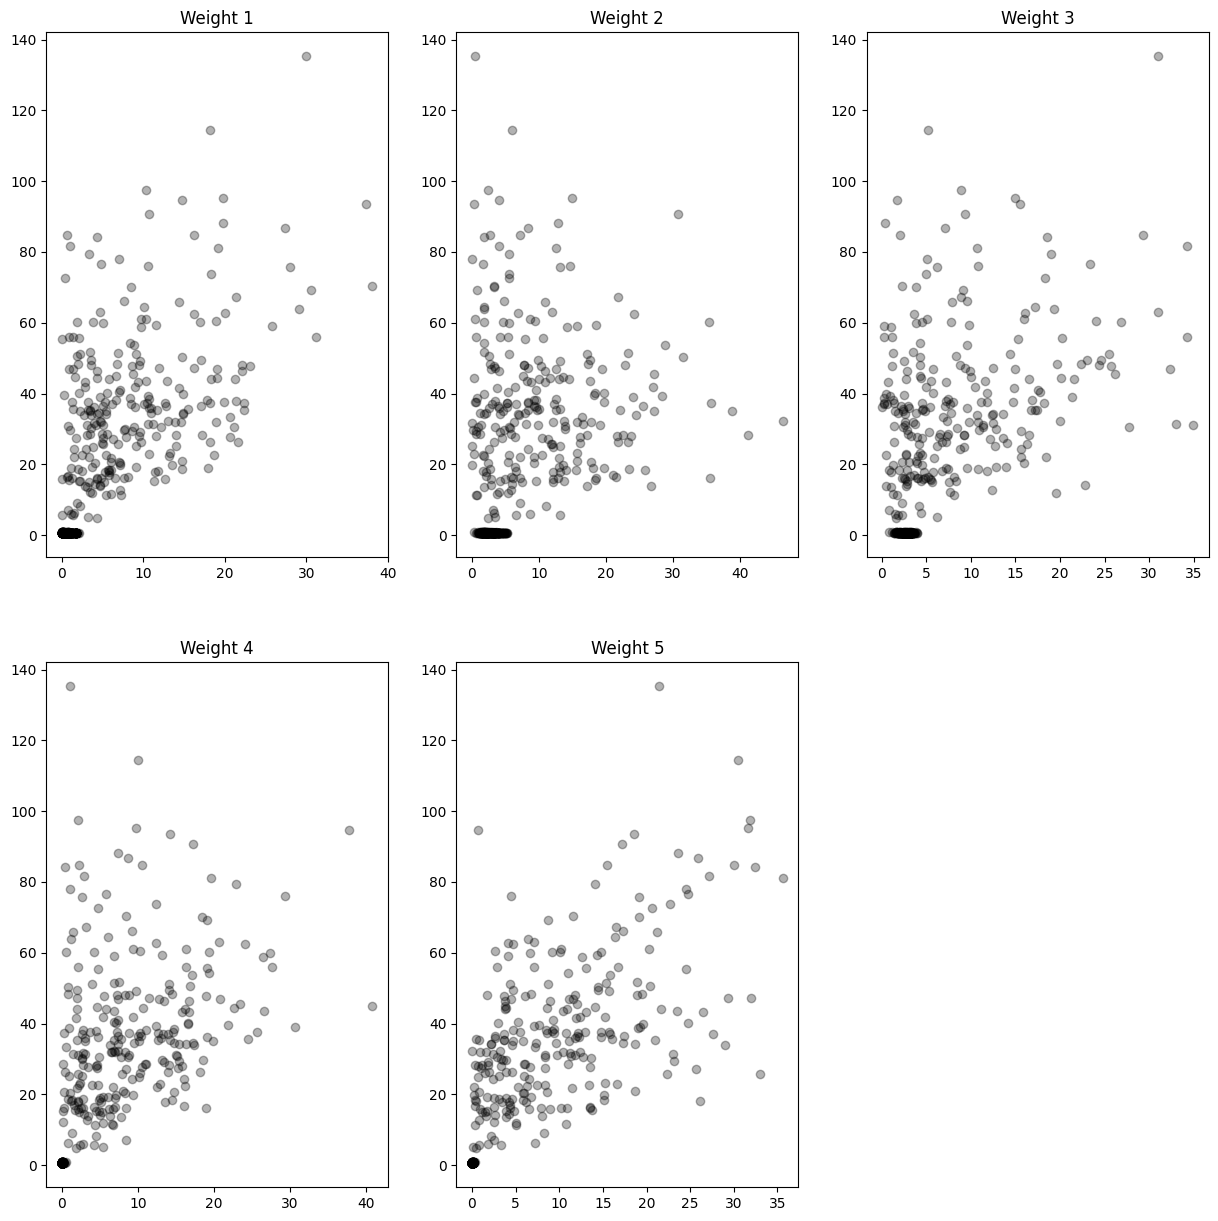

In [32]:
fig = plt.figure(figsize =(15, 15))
for i in range(nWeights):
    plt.subplot(2, 3, i + 1)
    plt.title("Weight " + str(i + 1))
    plt.scatter(masses[:, i], fitness, alpha = 0.3, color = '0')

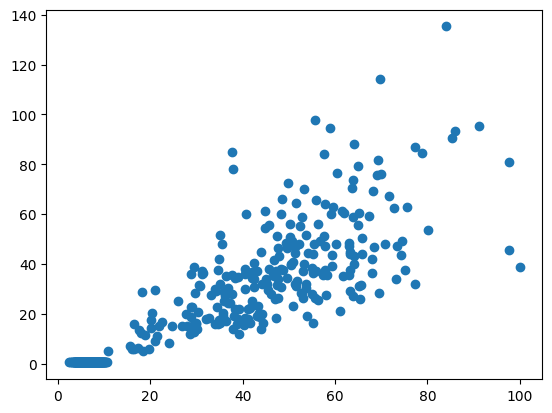

In [38]:
sumMasses = np.sum(masses, axis = 1)
plt.scatter(sumMasses, fitness)